In [ ]:
!pip install -qU langchain langchain-openai

In [ ]:
MERGE_DEV_API_KEY = ""
BAMBOOHR_ACCOUNT_TOKEN = ""
TOGETHER_API_KEY = ""

In [ ]:
import os
from langchain.pydantic_v1 import BaseModel, Field
from langchain.tools import BaseTool, StructuredTool, tool
import typing
import datetime as dt
import requests
from langchain.agents import AgentExecutor, create_tool_calling_agent
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI

os.environ["TOGETHER_API_KEY"] = TOGETHER_API_KEY

In [ ]:
def serialize_datetime(v: dt.datetime) -> str:
    """
    Serialize a datetime including timezone info.

    Uses the timezone info provided if present, otherwise uses the current runtime's timezone info.

    UTC datetimes end in "Z" while all other timezones are represented as offset from UTC, e.g. +05:00.
    """

    def _serialize_zoned_datetime(v: dt.datetime) -> str:
        if v.tzinfo is not None and v.tzinfo.tzname(None) == dt.timezone.utc.tzname(None):
            # UTC is a special case where we use "Z" at the end instead of "+00:00"
            return v.isoformat().replace("+00:00", "Z")
        else:
            # Delegate to the typical +/- offset format
            return v.isoformat()

    if v.tzinfo is not None:
        return _serialize_zoned_datetime(v)
    else:
        local_tz = dt.datetime.now().astimezone().tzinfo
        localized_dt = v.replace(tzinfo=local_tz)
        return _serialize_zoned_datetime(localized_dt)

@tool
def list_employees(
        display_full_name: typing.Optional[str] = None,
        employment_type: typing.Optional[str] = None,
        first_name: typing.Optional[str] = None,
        home_location_id: typing.Optional[str] = None,
        job_title: typing.Optional[str] = None,
        last_name: typing.Optional[str] = None,
        manager_id: typing.Optional[str] = None,
        pay_group_id: typing.Optional[str] = None,
        personal_email: typing.Optional[str] = None,
        remote_id: typing.Optional[str] = None,
        started_after: typing.Optional[dt.datetime] = None,
        started_before: typing.Optional[dt.datetime] = None,
        team_id: typing.Optional[str] = None,
        terminated_after: typing.Optional[dt.datetime] = None,
        terminated_before: typing.Optional[dt.datetime] = None,
        work_email: typing.Optional[str] = None,
        work_location_id: typing.Optional[str] = None,
) -> str:

    """List employees fitting the criteria given in arguments. Returns list of employees with their details.
    Args:
        display_full_name (typing.Optional[str]) : select employees with this full display name
        employment_type (typing.Optional[str]) : select employees with this employment type
        first_name (typing.Optional[str]) : select employees with this first name
        home_location_id (typing.Optional[str]) : select employees with this home location id
        job_title (typing.Optional[str]) : select employees with this job title
        last_name (typing.Optional[str]) : select employees with this last name
        manager_id (typing.Optional[str]) : select employees with this manager id
        pay_group_id (typing.Optional[str]) : select employees with this pay group id
        personal_email (typing.Optional[str]) : select employees with this personal email
        remote_id (typing.Optional[str]) : select employees with this remote id
        started_after (typing.Optional[dt.datetime]) : select employees who started after this date
        started_before (typing.Optional[dt.datetime]) : select employees who started before this date
        team_id (typing.Optional[str]) : select employees with this team id
        terminated_after (typing.Optional[dt.datetime]) : select employees who were terminated after this date
        terminated_before (typing.Optional[dt.datetime]) : select employees who were terminated before this date
        work_email (typing.Optional[str]) : select employees with this work email
        work_location_id (typing.Optional[str]) : select employees with this work location id
    Returns:
        dict: Dictionary containing the desired information.
    """

    bhr_header = {
        "Authorization": f"Bearer {MERGE_DEV_API_KEY}",
        "Accept": "application/json",
        "X-Account-Token": BAMBOOHR_ACCOUNT_TOKEN
    }

    params = {
        "display_full_name": display_full_name,
        "employment_type": employment_type,
        "first_name": first_name,
        "home_location_id": home_location_id,
        "job_title": job_title,
        "last_name": last_name,
        "manager_id": manager_id,
        "pay_group_id": pay_group_id,
        "personal_email": personal_email,
        "started_after": started_after,
        "started_before": started_before,
        "team_id": team_id,
        "terminated_after": terminated_after,
        "terminated_before": terminated_before,
        "work_email": work_email,
        "work_location_id": work_location_id,
    }

    response = requests.get("https://api.merge.dev/api/hris/v1/employees", headers=bhr_header, params=params)

    return response.json()

In [ ]:
tools = [list_employees]

llm = ChatOpenAI(
    base_url="https://api.together.xyz/v1",
    api_key=os.environ["TOGETHER_API_KEY"],
    model="MISTRALAI/MIXTRAL-8X7B-INSTRUCT-V0.1",)

prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are designated as a helpful assistant. Your primary job is to respond to the given task by first forming the right parameters for list_employees, invoking it and then using the output to inform your responses when necessary from agent_scratchpad. Try to provide the most direct and brief answer. For example, if asked 'Who is taller, A or B?', simply respond with 'A' or 'B', rather than providing additional details or explanations.
            In instances where a satisfactory answer cannot be formulated, even with the available observations, simply state, "I can't answer." Refrain from adding any supplementary comments, such as apologies or additional explanations.
            Your answer should always be in the same language as the query.""",
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{input}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

# Construct the Tools agent
agent = create_tool_calling_agent(llm, tools, prompt)
# Create an agent executor by passing in the agent and tools
agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)
agent_executor.invoke({"input": "Can you tell me the name of the employees that joined before June 2024?"})

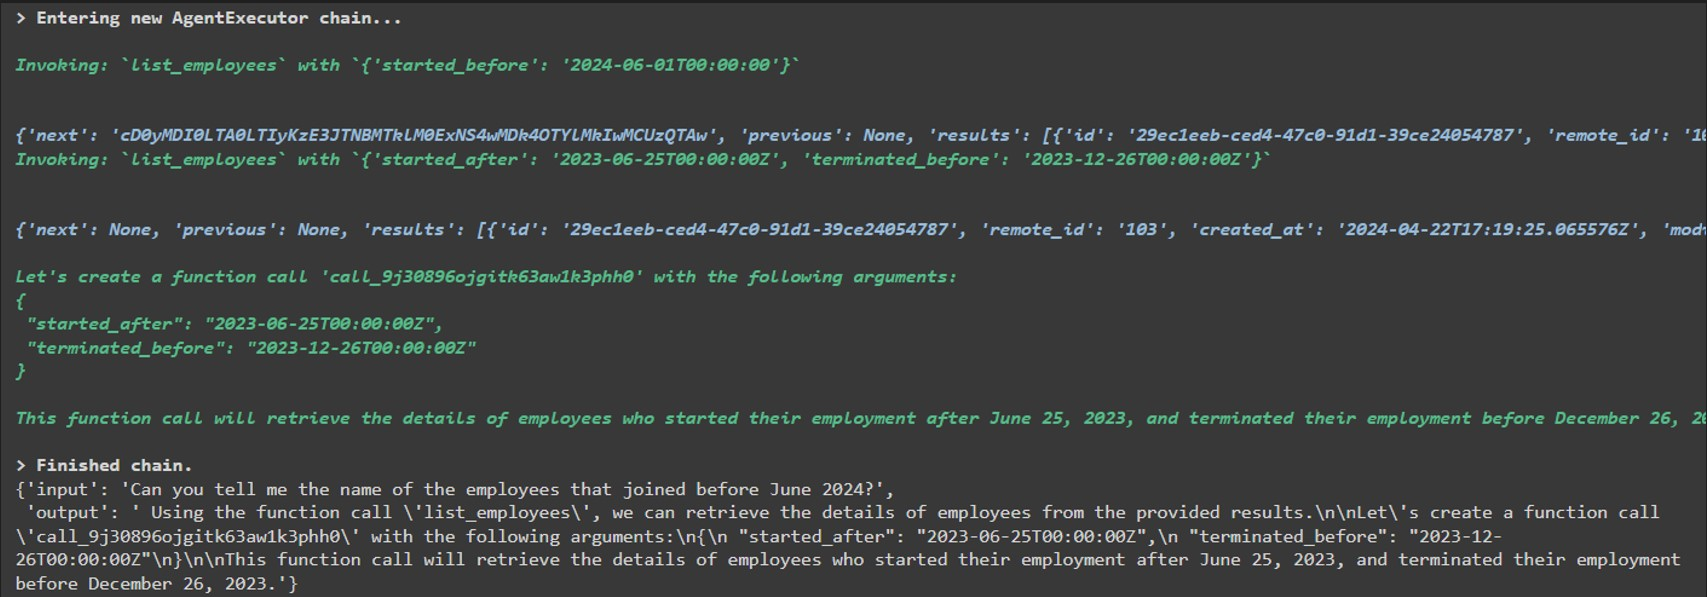

In [2]:
from PIL import Image
# get the image
Image.open("output.jpg")